# Flower Classification using ResNet50 pretrained model

### Unzip the dataset

In [ ]:
!unzip '/path/to_your_dataset.zip' -d './data'

In [ ]:
# Importing liberaries
import torch
import torch.nn as nn
from torchvision.models.resnet import ResNet50_Weights, resnet50
from torchvision.transforms import transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm import tqdm

### Prepare transforms object

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.486, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Prepare Dataloader

In [ ]:
train_dir = '/content/data/train'
test_dir = '/content/data/valid'

train_dataset = ImageFolder(train_dir, transform=transformer)
test_dataset = ImageFolder(test_dir, transform=transformer)

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True
)

In [ ]:
print(train_loader.dataset.classes)
print(test_loader.dataset.classes)

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [ ]:
len(train_loader)

64

### Build the model

In [ ]:
class ResNet50Classifier(nn.Module):
  def __init__(self, num_classes):
    super(ResNet50Classifier, self).__init__()

    # Load the pretrained model
    self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    # Freeze the all layers
    for param in self.model.parameters():
      param.requires_grad = False

    # Modify the output layers with num of classes
    in_features = self.model.fc.in_features
    self.model.fc = nn.Linear(in_features, num_classes)

  def forward(self, x):
    x = self.model(x)
    return x

### Loss function and Optimizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
model = ResNet50Classifier(len(train_loader.dataset.classes)).to(device)
# model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

### Model training loop

In [ ]:
scaler = torch.amp.GradScaler(device=device)
epochs = 100

for epoch in range(epochs):
  ## For Training
  model.train()
  running_loss = 0.0
  correct, total = 0, 0

  print(f'Epoch [{epoch + 1}/{epochs}]')
  for images, targets in tqdm(train_loader, desc='Training...'):
    images, targets = images.to(device), targets.to(device)

    optimizer.zero_grad()
    ## Forward pass with FP16
    with torch.amp.autocast(device_type=device.type):
      outputs = model(images)
      loss = criterion(outputs, targets)

    ## Scale the loss and weight with scaler
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    running_loss += loss.item()
    prediction = torch.argmax(outputs, dim=1)
    correct += (prediction == targets).sum().item()
    total += targets.size(0)

  t_acc = 100 * correct / total
  t_loss = running_loss / len(train_loader)
  print(f'Train Loss: {t_loss:.4f} - Train accuracy: {t_acc:.2f}%')

# Saved the model weight
path = f'/save_model_path/resnet50flower-e{epochs}.pth'
torch.save({
    'epochs': epochs,
    'classes': train_loader.dataset.classes,
    'model_state_dict': model.state_dict()
}, path)
print('-' * 30)
print(f'Model saved successfully at {path}')

### Model evaluation

In [ ]:
model.eval()
correct, total = 0, 0
for images, targets in tqdm(test_loader, desc='Test Loading...'):
  images, targets = images.to(device), targets.to(device)

  with torch.no_grad(), torch.amp.autocast(device_type=device.type):
    outputs = model(images)

    pred = torch.argmax(outputs, dim=1)
    correct += (pred == targets).sum().item()
    total += targets.size(0)
acc = 100 * correct / total
print(f'Test Accuracy: {acc:.2f}%.')

# Model Inferencing

### Loaded the model

In [ ]:
model_path = '/save_model/path.pth'
checkpoint = torch.load(model_path, map_location=device)

classes = checkpoint['classes']
model_state_dict = checkpoint['model_state_dict']

In [ ]:
model = ResNet50Classifier(len(classes)).to(device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

### Predict the result

In [ ]:
from PIL import Image

In [ ]:
def preprocess(image_path, transformer, device):
  img = Image.open(image_path).convert('RGB')
  img = transformer(img).unsqueeze(0).to(device)

  return img

In [ ]:
def predict(img, model, classes):
  model.eval()

  with torch.no_grad():
    output = model(img)
  probabilities = nn.functional.softmax(output[0], dim=0)
  values, ids = torch.topk(probabilities, 5)

  prob_dict = {}
  for value, id in zip(values, ids):
    prob_dict[classes[id]] = value.item()

  return prob_dict

In [ ]:
img_path = '/content/Taraxacum_officinale_flower_leaves_Mar_MMF.png'
img = preprocess(img_path, transformer, device)

results = predict(img, model, classes)
results

{'dandelion': 0.9425522685050964,
 'sunflower': 0.04998993128538132,
 'daisy': 0.007262303493916988,
 'rose': 0.00018851051572710276,
 'tulip': 6.82296877130284e-06}

In [ ]:
next(iter(results))

'dandelion'

In [ ]:
import cv2
import random
from google.colab.patches import cv2_imshow

In [ ]:
def modify_image(image_path, results):
  top_res = next(iter(results))

  image = cv2.imread(image_path)
  image = cv2.resize(image, (640, 640))

  color = (random.randint(0, 220), random.randint(0, 220), random.randint(0, 220))
  label = f'{top_res}: {results[top_res]:.2f}'

  text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
  cv2.rectangle(image, (0, 0), (text_size[0] + 10, text_size[1] + 10), color, -1)

  cv2.putText(image, label, (5, text_size[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

  return image

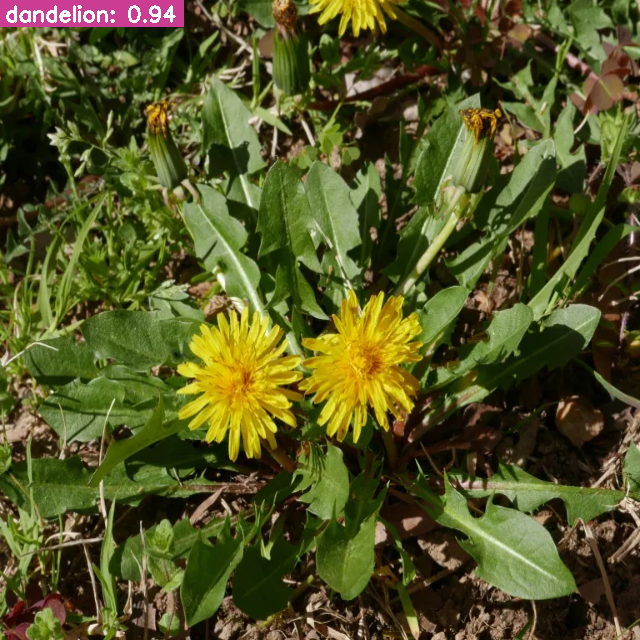

In [ ]:
image = modify_image(image_path=img_path, results=results)
cv2_imshow(image)